In [13]:
import tqdm
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision.utils as vutils
from pathlib import Path
import numpy as np

data\images\0_2000.jpg
0


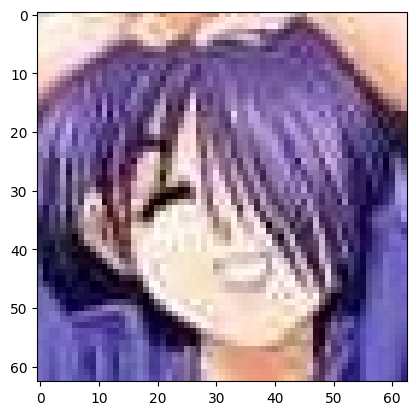

In [8]:
# images_path = Path("./data/images/")
# im_list = list(images_path.glob("*.jpg"))
# print(f"number of images = {len(im_list)}")
for im_name in im_list:
  print(im_name)
  im = cv2.imread(str(im_name))
  print(np.min(im))
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  plt.imshow(im)
  plt.show()
  break

In [24]:
batch = 64
trans = transforms.Compose([transforms.Resize((64,64)),
                           transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
ds = datasets.ImageFolder(root="./data", transform=trans)
data = torch.utils.data.DataLoader(ds, batch_size=batch, shuffle=True, num_workers=12)


In [25]:
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available!


In [34]:
import torch.nn as nn

nz = 100
ngf = 64
nc = 3
ndf = 64
image_size = 64

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [35]:
from torchsummary import summary
generator = Generator(1)
generator = generator.cuda()
generator.apply(weights_init)
print(summary(generator, (nz, 1,1)))
discriminator = Discriminator(1)
discriminator = discriminator.cuda()
discriminator.apply(weights_init)
#discriminator = discriminator.cuda()
print(summary(discriminator, (3, image_size, image_size)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [36]:
lr = 0.0002
beta1 = 0.5
gen_loss_f = torch.nn.BCELoss()
disc_loss_f = torch.nn.BCELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
disc_optim = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
fixed_noise= torch.randn([batch, nz, 1, 1])
fixed_noise = fixed_noise.cuda()
img_list = []
epochs = 1
g_losses = []
d_losses = []


In [37]:

iters = 0
for epoch in range(epochs):

    for i, (images, _) in enumerate(data):
        #print(images.shape)
        images = images.cuda()
        b_size = images.size(0)
        fake_input = torch.randn([b_size, nz, 1, 1], device=device)
        fake_images = generator(fake_input)
        real_labels = torch.ones((b_size,), device=device )
        fake_labels = torch.zeros((b_size,), device=device)
        fake_model_labels = discriminator(fake_images).view(-1)
        #print(fake_model_labels)
        gen_optim.zero_grad()
        g_loss = gen_loss_f(real_labels, fake_model_labels)
        D_G_z2 = fake_model_labels.mean().item()
        g_loss.backward()
        gen_optim.step()
        g_losses.append(g_loss.item())

        disc_optim.zero_grad()
        fake_model_labels = discriminator(fake_images.detach()).view(-1)
        fake_loss = disc_loss_f(fake_labels, fake_model_labels)
        fake_loss.backward()
        D_G_z1 = fake_model_labels.mean().item()
        real_model_labels = discriminator(images).view(-1)
        D_x = real_model_labels.mean().item()
        real_loss = disc_loss_f(real_labels, real_model_labels)
        real_loss.backward()
        errD = real_loss + fake_loss

        disc_optim.step()
        d_losses.append(errD)


        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(data),
                     errD.item(), fake_loss.item(), D_x, D_G_z1, D_G_z2))


        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
     

[0/1][0/994]	Loss_D: 97.7122	Loss_G: 65.6800	D(x): 0.6797	D(G(z)): 0.6568 / 0.6568
[0/1][50/994]	Loss_D: nan	Loss_G: nan	D(x): nan	D(G(z)): nan / nan
[0/1][100/994]	Loss_D: nan	Loss_G: nan	D(x): nan	D(G(z)): nan / nan
[0/1][150/994]	Loss_D: nan	Loss_G: nan	D(x): nan	D(G(z)): nan / nan
[0/1][200/994]	Loss_D: nan	Loss_G: nan	D(x): nan	D(G(z)): nan / nan
[0/1][250/994]	Loss_D: nan	Loss_G: nan	D(x): nan	D(G(z)): nan / nan
[0/1][300/994]	Loss_D: nan	Loss_G: nan	D(x): nan	D(G(z)): nan / nan
[0/1][350/994]	Loss_D: nan	Loss_G: nan	D(x): nan	D(G(z)): nan / nan
[0/1][400/994]	Loss_D: nan	Loss_G: nan	D(x): nan	D(G(z)): nan / nan


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())